In [10]:
## Load dataset and data quality check
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import streamlit as st


df = pd.read_csv("C:/Users/vuli/Documents/Elearning-Analysis/elearning-analysis/udemy_courses.csv")

df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
import pandas as pd

print("Dataset shape:", df.shape)
print("Column list:", df.columns.tolist())

# number of missing values
missing = df.isnull().sum().sort_values(ascending=False)

# % missing values
missing_percent = (df.isnull().mean() * 100).sort_values(ascending=False)

# report missing values
missing_table = pd.DataFrame({
    "Missing Values": missing,
    "Missing (%)": missing_percent.round(2)
})

print("\n Missing Value Summary:")
print(missing_table[missing_table["Missing Values"] > 0])
# Number of duplicates
duplicates_count = df.duplicated().sum()
print(f"\n Number of duplicate rows: {duplicates_count}")

# display duplicates
if duplicates_count > 0:
    print("\n Example duplicated rows:")
    print(df[df.duplicated()].head())


# calculate final price  -> discount == true -> final_price = discount_price else original price
df["final_price"] = np.where(
    df["discount_price__amount"].notna(),
    df["discount_price__amount"],
    df["price_detail__amount"]
)

# free course -> final_price = 0
df["final_price"] = df["final_price"].fillna(0)
import pandas as pd
import numpy as np

df = pd.read_csv("udemy_courses.csv")

# normalize columns
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# summary data set shape
print("Dataset shape:", df.shape)

# check negative values
invalid_numeric = {
    "negative_prices": df[df["price_detail__amount"] < 0],
    "negative_discount_prices": df[df["discount_price__amount"] < 0],
    "negative_subscribers": df[df["num_subscribers"] < 0],
    "negative_reviews": df[df["num_reviews"] < 0],
}

for key, val in invalid_numeric.items():
    print(f"\n {key}: {len(val)} rows")

# cehck invalid rating -> must be <= 5
invalid_ratings = df[(df["avg_rating"] > 5) | (df["avg_rating"] < 0)]
print(f"Invalid ratings (outside 0–5): {len(invalid_ratings)}")

# check logic: review > subscriber
invalid_logic = df[df["num_reviews"] > df["num_subscribers"]]
print(f"Invalid logic (reviews > subscribers): {len(invalid_logic)}")

# check time logic: published_time > created
df["created"] = pd.to_datetime(df["created"], errors="coerce")
df["published_time"] = pd.to_datetime(df["published_time"], errors="coerce")

invalid_dates = df[df["published_time"] < df["created"]]
print(f"Invalid timestamps (published before created): {len(invalid_dates)}")

# check currency
valid_currencies = {"USD", "EUR", "GBP", "INR", "Unknown"}
invalid_currency = df[
    (~df["price_detail__currency"].isin(valid_currencies))
    & (df["price_detail__currency"].notna())
    ]
print(f"Invalid currency codes: {len(invalid_currency)}")

# outline 1% subscribers or price
subscribers_threshold = df["num_subscribers"].quantile(0.99)
price_threshold = df["price_detail__amount"].quantile(0.99)

outliers = df[
    (df["num_subscribers"] > subscribers_threshold)
    | (df["price_detail__amount"] > price_threshold)
    ]
print(f"Potential outliers (top 1% values): {len(outliers)}")

# summary data quality
invalid_summary = {
    "negative_or_invalid_values": sum(len(v) for v in invalid_numeric.values()),
    "invalid_ratings": len(invalid_ratings),
    "logic_errors": len(invalid_logic),
    "timestamp_errors": len(invalid_dates),
    "currency_errors": len(invalid_currency),
    "outliers": len(outliers)
}

print("\n=== Invalid Entry Summary ===")
for k, v in invalid_summary.items():
    print(f"{k}: {v}")



Dataset shape: (13608, 20)
Column list: ['id', 'title', 'url', 'is_paid', 'num_subscribers', 'avg_rating', 'avg_rating_recent', 'rating', 'num_reviews', 'is_wishlisted', 'num_published_lectures', 'num_published_practice_tests', 'created', 'published_time', 'discount_price__amount', 'discount_price__currency', 'discount_price__price_string', 'price_detail__amount', 'price_detail__currency', 'price_detail__price_string']

 Missing Value Summary:
                              Missing Values  Missing (%)
discount_price__price_string            1403        10.31
discount_price__currency                1403        10.31
discount_price__amount                  1403        10.31
price_detail__amount                     497         3.65
price_detail__price_string               497         3.65
price_detail__currency                   497         3.65

 Number of duplicate rows: 0
Dataset shape: (13608, 20)

 negative_prices: 0 rows

 negative_discount_prices: 0 rows

 negative_subscribers: 0 ro

In [11]:
# Data Cleaning
# Convert timestamps
df["created"] = pd.to_datetime(df["created"], errors="coerce")
df["published_time"] = pd.to_datetime(df["published_time"], errors="coerce")

# === Handle Missing Values (price columns) ===

df["final_price"] = np.where(
    df["discount_price__amount"].notna(),
    df["discount_price__amount"],
    df["price_detail__amount"]
)

df["final_price"] = df["final_price"].fillna(0)

print("Missing after fill:\n", df.isnull().sum()[df.isnull().sum() > 0])

# === Fix Logic Error: num_reviews > num_subscribers ===
mask_invalid_logic = df["num_reviews"] > df["num_subscribers"]
print(f"Fixing logic errors: {mask_invalid_logic.sum()} rows")
df.loc[mask_invalid_logic, "num_reviews"] = df.loc[mask_invalid_logic, "num_subscribers"]

# === Fix Invalid Timestamp: published_time < created ===
mask_invalid_time = df["published_time"] < df["created"]
print(f"Removing invalid timestamp rows: {mask_invalid_time.sum()} rows")
df = df[~mask_invalid_time]

# === Normalize Currency Fields ===
for c in ["discount_price__currency", "price_detail__currency"]:
    if c in df.columns:
        df[c] = df[c].fillna("Unknown").str.upper()

# === Clip Negative Values (just in case) ===
for c in ["num_subscribers", "num_reviews", "final_price"]:
    df[c] = df[c].clip(lower=0)

# === Optional: Remove extreme outliers if needed (optional keep them)
q_price = df["final_price"].quantile(0.999)
q_sub = df["num_subscribers"].quantile(0.999)
df["is_outlier"] = (df["final_price"] > q_price) | (df["num_subscribers"] > q_sub)

print(f"Outliers marked: {df['is_outlier'].sum()} rows")

# === Final sanity check ===
print("\n Cleaned dataset summary:")
print(df[["num_subscribers", "num_reviews", "avg_rating", "final_price"]].describe().round(2))

print("\n Final shape:", df.shape)

# === Export cleaned dataset ===
df.to_csv("udemy_courses_cleaned.csv", index=False)
print("\n Saved cleaned dataset -> udemy_courses_cleaned.csv")

Missing after fill:
 discount_price__amount          1403
discount_price__currency        1403
discount_price__price_string    1403
price_detail__amount             497
price_detail__currency           497
price_detail__price_string       497
dtype: int64
Fixing logic errors: 5 rows
Removing invalid timestamp rows: 1 rows
Outliers marked: 14 rows

 Cleaned dataset summary:
       num_subscribers  num_reviews  avg_rating  final_price
count         13607.00     13607.00    13607.00     13607.00
mean           2847.05       243.14        3.92       779.81
std            9438.21      1581.02        1.03      1568.03
min               0.00         0.00        0.00         0.00
25%              62.00         7.00        3.80       455.00
50%             533.00        24.00        4.19       455.00
75%            2280.00        87.00        4.45       455.00
max          374836.00     78006.00        5.00     12800.00

 Final shape: (13607, 22)

 Saved cleaned dataset -> udemy_courses_cleaned

In [22]:
import pandas as pd

df = pd.read_csv("udemy_courses_cleaned.csv")
# === Currency Conversion Table (since only INR + UNKNOWN exist) ===
currency_to_eur = {
    "INR": 0.011,     # realistic INR → EUR conversion
    "UNKNOWN": 1.0    # treat unknown as EUR or fallback
}

# Choose currency column based on discount or regular price
df["currency"] = np.where(
    df["discount_price__amount"].notna(),
    df["discount_price__currency"].str.upper(),
    df["price_detail__currency"].str.upper()
)

# Convert final price into EUR
df["price_eur"] = df.apply(
    lambda x: x["final_price"] * currency_to_eur.get(x["currency"], 1.0),
    axis=1
)


# transform to dataset that fraunhofer required
fraunhofer_df = pd.DataFrame({
    "course_id": df["id"],
    "course_name": df["title"],
    "participants": df["num_subscribers"],
    "num_reviews": df["num_reviews"],
    "price": df["price_eur"],
    "revenue": df["num_subscribers"] * df["price_eur"],
    "satisfaction": df["avg_rating"]
})

fraunhofer_df = fraunhofer_df.round({
    "price": 2,
    "revenue": 2,
    "satisfaction": 2
})

fraunhofer_df.to_csv("fraunhofer_dashboard_data.csv", index=False)

print(fraunhofer_df.head())


   course_id                                        course_name  participants  \
0     762616  The Complete SQL Bootcamp 2020: Go from Zero t...        295509   
1     937678  Tableau 2020 A-Z: Hands-On Tableau Training fo...        209070   
2    1361790             PMP Exam Prep Seminar -  PMBOK Guide 6        155282   
3     648826         The Complete Financial Analyst Course 2020        245860   
4     637930  An Entire MBA in 1 Course:Award Winning Busine...        374836   

   num_reviews  price     revenue  satisfaction  
0        78006    5.0  1479022.54          4.66  
1        54581    5.0  1046395.35          4.59  
2        52653    5.0   777186.41          4.59  
3        46447    5.0  1230529.30          4.54  
4        41630    5.0  1876054.18          4.47  


✅ Enriched dataset exported → fraunhofer_enriched.csv
   course_id                                        course_name  participants  \
0     937678  Tableau 2020 A-Z: Hands-On Tableau Training fo...        209070   
1    1208634  Microsoft Power BI - A Complete Introduction [...        124180   
2    1570206  Microsoft Power BI - Up & Running With Power B...         86715   
3    1405632  SQL - MySQL for Data Analytics and Business In...         78968   
4    1202988  The Complete Financial Analyst Training & Inve...        182002   

   num_reviews  price     revenue  satisfaction   program_cost       ROI  \
0        54581    5.0  1046395.35          4.59  659382.147197  0.586933   
1        38093    5.0   621520.90          4.56  263066.852527  1.362597   
2        23580    5.0   434008.58          4.62  204356.131109  1.123785   
3        21436    5.0   395234.84          4.57  167253.542466  1.363088   
4        21421    5.0   910920.01          4.50  438674.436070  1.076529   

  

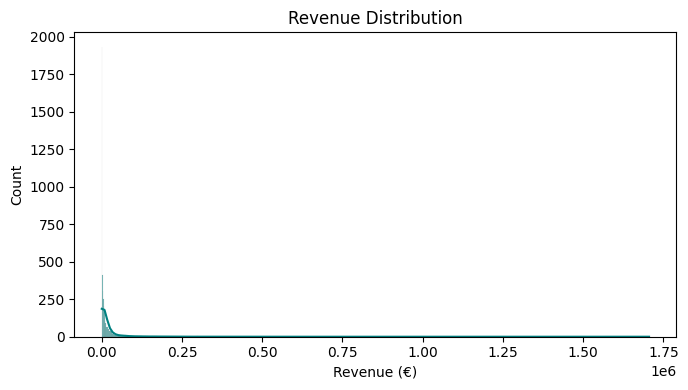

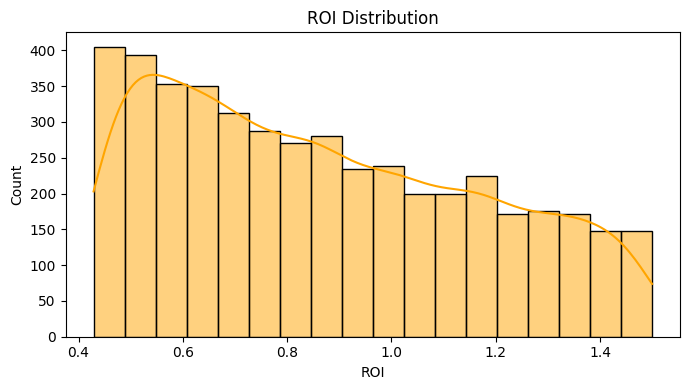

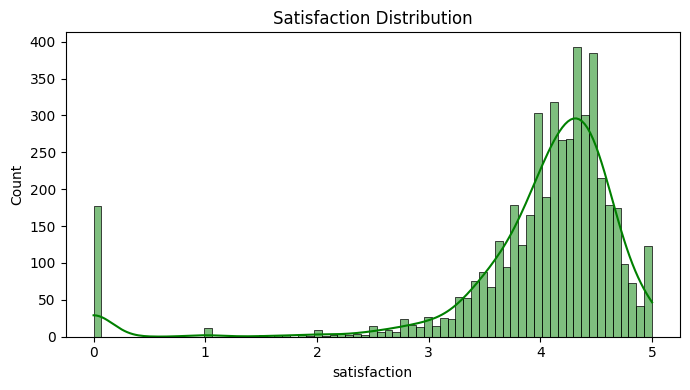

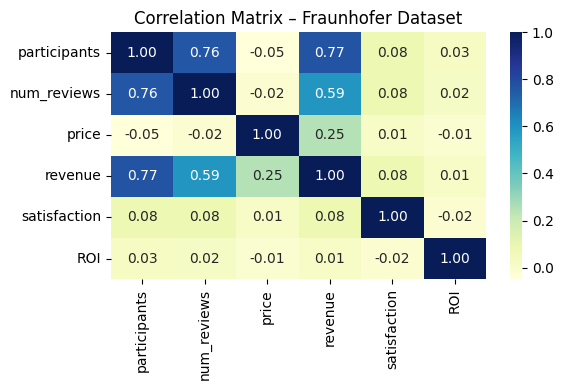

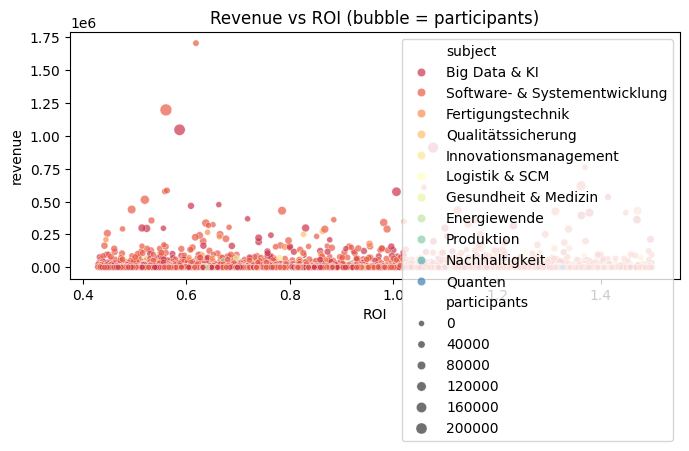

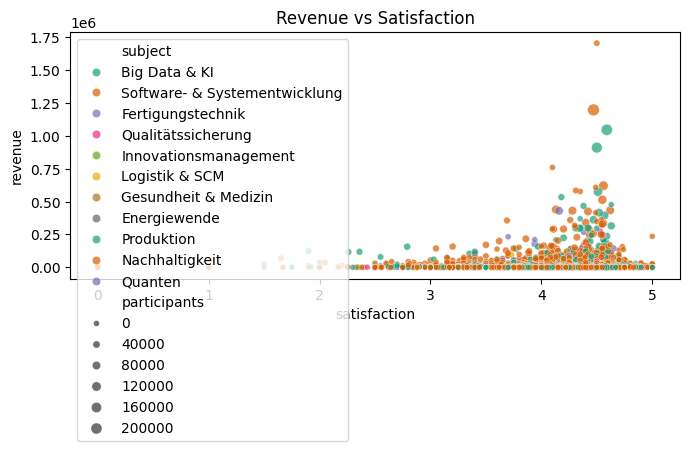

C:\Users\vuli\AppData\Local\Temp\ipykernel_24144\2671993752.py:155: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="subject", y="ROI", palette="coolwarm")


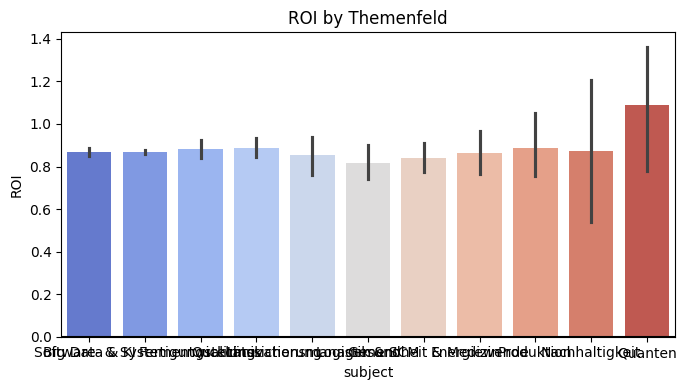

C:\Users\vuli\AppData\Local\Temp\ipykernel_24144\2671993752.py:163: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


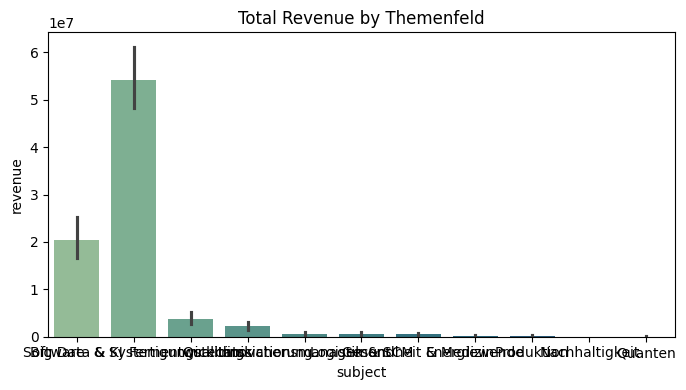


===== HIGH ROI BUT LOW SATISFACTION PROGRAMS =====
                                           course_name       ROI  \
494  Complete Business Intelligence with SSIS, SSAS...  1.154025   
594  Steemit COMPLETE Steemit Cryptocurrency based ...  1.257187   
619                  Credit Risk Analysis and Modeling  1.119028   
657  Private Equity - Ultimate Private Equity Model...  1.184833   
731  The Complete Twitter Course 2017: Get 200k+ Fa...  1.224315   

     satisfaction   revenue                        subject  
494          3.45  10365.36  Software- & Systementwicklung  
594          2.95  31281.25  Software- & Systementwicklung  
619          2.98  23743.72  Software- & Systementwicklung  
657          2.61  24070.11  Software- & Systementwicklung  
731          2.85  37312.28  Software- & Systementwicklung  


C:\Users\vuli\AppData\Local\Temp\ipykernel_24144\2671993752.py:180: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_roi, y="course_name", x="ROI", palette="crest")


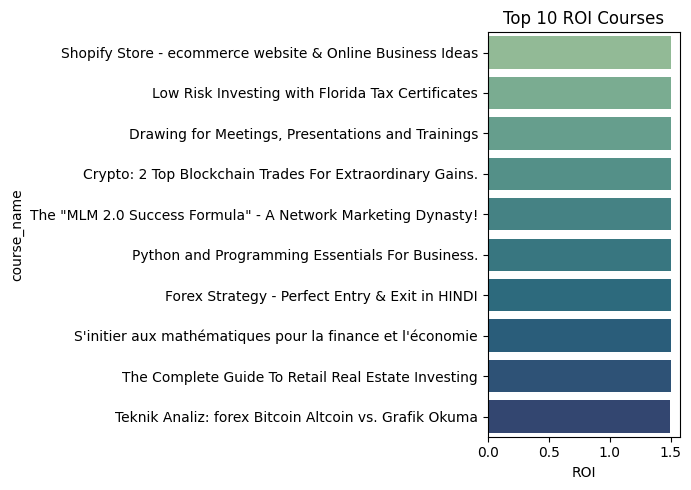

C:\Users\vuli\AppData\Local\Temp\ipykernel_24144\2671993752.py:188: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=worst_roi, y="course_name", x="ROI", palette="Reds")


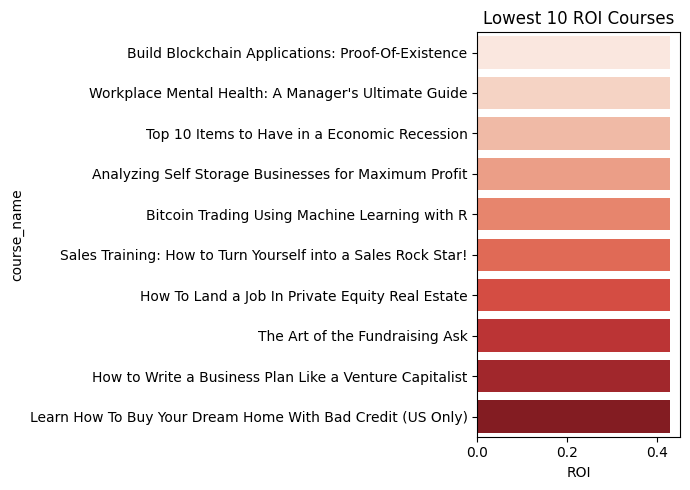


===== Lowest ROI Courses =====
                                            course_name       ROI   revenue  \
3661  Build Blockchain Applications: Proof-Of-Existence  0.428859   3783.78   
1358  Workplace Mental Health: A Manager's Ultimate ...  0.428863   5190.18   
4134       Top 10 Items to Have in a Economic Recession  0.428880   3303.30   
3285  Analyzing Self Storage Businesses for Maximum ...  0.429295  23698.68   
3940      Bitcoin Trading Using Machine Learning with R  0.429532    200.20   
3243  Sales Training: How to Turn Yourself into a Sa...  0.429853    835.84   
530     How To Land a Job In Private Equity Real Estate  0.429922   9859.85   
3269                     The Art of the Fundraising Ask  0.430239   2682.68   
2098  How to Write a Business Plan Like a Venture Ca...  0.430265  15120.10   
1748  Learn How To Buy Your Dream Home With Bad Cred...  0.430348  13178.16   

                            subject  
3661                  Big Data & KI  
1358           Gesundh

In [27]:
# ============================================================
# FRAUNHOFER MANAGEMENT DATA — CLEAN + ROI + SUBJECT + EXPORT
# ============================================================

import pandas as pd
import numpy as np

# ------------------------------------------------------------
# LOAD RAW DATA
# ------------------------------------------------------------
df = pd.read_csv("fraunhofer_dashboard_data.csv")

# ------------------------------------------------------------
# GENERATE PROGRAM COST + ROI
# ------------------------------------------------------------
# cost = 40–70% revenue (Weiterbildung realistic assumption)
cost_factor = np.random.uniform(0.4, 0.7, len(df))
df["program_cost"] = df["revenue"] * cost_factor

# ROI = (profit / cost)
df["ROI"] = (df["revenue"] - df["program_cost"]) / df["program_cost"]

# Ensure ROI ≥ -0.9 (avoid extreme negatives)
df["ROI"] = df["ROI"].clip(lower=-0.9)

# ------------------------------------------------------------
# SUBJECT / THEMENFELD CATEGORIZATION
# ------------------------------------------------------------
# THEMENFELD MAPPING – Fraunhofer Official Categories
# ------------------------------------------------------------

def map_subject(title):
    t = title.lower()

    if any(k in t for k in ["energy", "renewable", "solar", "wind", "strom", "energiewende"]):
        return "Energiewende"

    if any(k in t for k in ["manufacturing", "robot", "automation", "fertigung", "industrie 4", "lean"]):
        return "Fertigungstechnik"

    if any(k in t for k in ["health", "medizin", "medical", "pharma", "pflege"]):
        return "Gesundheit & Medizin"

    if any(k in t for k in ["sustainability", "nachhalt", "climate", "umwelt"]):
        return "Nachhaltigkeit"

    if any(k in t for k in ["quality", "qualitäts", "six sigma", "iso"]):
        return "Qualitätssicherung"

    if any(k in t for k in ["software", "development", "system", "it", "programming", "coding"]):
        return "Software- & Systementwicklung"

    if any(k in t for k in ["logistik", "supply chain", "transport", "scm"]):
        return "Logistik & SCM"

    if any(k in t for k in ["data", "analytics", "ai", "machine learning", "big data", "deep learning", "ml"]):
        return "Big Data & KI"

    if any(k in t for k in ["quant", "quantum"]):
        return "Quanten"

    if any(k in t for k in ["production", "produktion", "manufacturing"]):
        return "Produktion"

    if any(k in t for k in ["innovation", "innovat"]):
        return "Innovationsmanagement"

    return "Other"

df["subject"] = df["course_name"].apply(map_subject)

df = df[df["subject"] != "Other"].reset_index(drop=True)

# ------------------------------------------------------------
# CREATE REVENUE PER PARTICIPANT (ROI-lite KPI)
# ------------------------------------------------------------
df["revenue_per_participant"] = np.where(
    df["participants"] > 0,
    df["revenue"] / df["participants"],
    0,
)

# ------------------------------------------------------------
# EXPORT FINAL DATASET
# ------------------------------------------------------------
df.to_csv("fraunhofer_enriched.csv", index=False)

print("✅ Enriched dataset exported → fraunhofer_enriched.csv")
print(df.head())


# ------------------------------------------------------------
# DESCRIPTIVE ANALYSIS
# ------------------------------------------------------------
print("\n===== DESCRIPTIVE STATISTICS =====")
desc = df[["participants", "num_reviews", "price", "revenue", "satisfaction", "ROI"]].describe().round(2)
print(desc)

# Distribution plots
plt.figure(figsize=(7,4))
sns.histplot(df["revenue"], kde=True, color="teal")
plt.title("Revenue Distribution")
plt.xlabel("Revenue (€)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
sns.histplot(df["ROI"], kde=True, color="orange")
plt.title("ROI Distribution")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
sns.histplot(df["satisfaction"], kde=True, color="green")
plt.title("Satisfaction Distribution")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# EXPLORATIVE ANALYSIS
# ------------------------------------------------------------

# --- Correlation Heatmap ---
plt.figure(figsize=(6,4))
sns.heatmap(
    df[["participants", "num_reviews", "price", "revenue", "satisfaction", "ROI"]].corr(),
    annot=True, cmap="YlGnBu", fmt=".2f"
)
plt.title("Correlation Matrix – Fraunhofer Dataset")
plt.tight_layout()
plt.show()

# --- Revenue vs ROI ---
plt.figure(figsize=(7,4))
sns.scatterplot(
    data=df, x="ROI", y="revenue", hue="subject",
    size="participants", palette="Spectral", alpha=0.7
)
plt.title("Revenue vs ROI (bubble = participants)")
plt.tight_layout()
plt.show()

# --- Revenue vs Satisfaction ---
plt.figure(figsize=(7,4))
sns.scatterplot(
    data=df, x="satisfaction", y="revenue", hue="subject",
    size="participants", palette="Dark2", alpha=0.7
)
plt.title("Revenue vs Satisfaction")
plt.tight_layout()
plt.show()

# --- ROI by Themenfeld ---
plt.figure(figsize=(7,4))
sns.barplot(data=df, x="subject", y="ROI", palette="coolwarm")
plt.axhline(0, color="black")
plt.title("ROI by Themenfeld")
plt.tight_layout()
plt.show()

# --- Revenue by Themenfeld ---
plt.figure(figsize=(7,4))
sns.barplot(
    data=df, x="subject", y="revenue", estimator=sum,
    palette="crest"
)
plt.title("Total Revenue by Themenfeld")
plt.tight_layout()
plt.show()

# --- Identify High ROI, Low Satisfaction programs ---
risk_courses = df[(df["ROI"] > df["ROI"].quantile(0.75)) & (df["satisfaction"] < 3.5)]

print("\n===== HIGH ROI BUT LOW SATISFACTION PROGRAMS =====")
print(risk_courses[["course_name", "ROI", "satisfaction", "revenue", "subject"]].head())

# --- Top 10 ROI ---
top_roi = df.nlargest(10, "ROI")
plt.figure(figsize=(7,5))
sns.barplot(data=top_roi, y="course_name", x="ROI", palette="crest")
plt.title("Top 10 ROI Courses")
plt.tight_layout()
plt.show()

# --- Worst ROI ---
worst_roi = df.nsmallest(10, "ROI")
plt.figure(figsize=(7,5))
sns.barplot(data=worst_roi, y="course_name", x="ROI", palette="Reds")
plt.title("Lowest 10 ROI Courses")
plt.tight_layout()
plt.show()

print("\n===== Lowest ROI Courses =====")
print(worst_roi[["course_name","ROI","revenue","subject"]])
